**Acropora tenuis spp in the central Philippines - isolation by distance within cryptic taxa**\
_Inputs:_\
Calculating Fst and linearized Fst between each pair of sites\
Calculating great circle distances between each pair of sites\
Linear regressions and Mantel tests\
Figures\
Created by Jaelyn Bos, November 2024

In [1]:
.libPaths('/hb/home/jbos/.conda/envs/vcfR')
.libPaths("/hb/home/jbos/.conda/envs/vcfR/lib/R/library")
#.libPaths('/hb/software/apps/r/conda3-4.4.1/lib/R/library')
#.libPaths('/hb/home/jbos/R/x86_64-conda-linux-gnu-library/4.4')

In [2]:
.libPaths()

[1] "/hb/home/jbos/.conda/envs/vcfR/lib/R/library"  
[2] "/hb/software/apps/r/conda3-4.4.1/lib/R/library"

In [3]:
#Load required packages
library(adegenet)
library(hierfstat)
library(tidyverse)
library(vegan)
library(vcfR)
library(sp)
library(sf)

Loading required package: ade4


   /// adegenet 2.1.10 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()




Attaching package: ‘hierfstat’


The following objects are masked from ‘package:adegenet’:

    Hs, read.fstat


── Attaching core tidyverse packages ───────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-8


   *****       ***   vcfR   ***       *****
   This

In [4]:
#Input: site string
#Output: island tag
island_sel <- function(string){
  x<-substr(string, start = 1, stop = 3)
  return(x)
}

In [5]:
#Inputs: wide form FSTs and dataframe of individuals corresponding to each population
#Output: long form FSTs. Columns: siteA	siteB	fst	siteA_counts	siteB_counts	mean_counts
fst_transform<-function(fsts,indpops){
    fst_long<-pivot_longer(fsts,cols=colnames(fsts)[2:length(colnames(fsts))],names_to='siteB',values_to='fst')
    colnames(fst_long)<-c('siteA','siteB','fst')
    fst_long<-fst_long[!is.nan(fst_long$fst),]
    dum<-as.data.frame(table(indpops$Population))
    colnames(dum)<-c('siteA','siteA_counts')
    fst_long<-left_join(fst_long,dum,by='siteA')
    colnames(dum)<-c('siteB','siteB_counts')
    fst_long<-left_join(fst_long,dum,by='siteB')
    fst_long$mean_counts<-rowMeans(as.data.frame(cbind(fst_long$siteA_counts,fst_long$siteB_counts)))
    return(fst_long)
}

In [6]:
#Inputs: wide form FSTs
#Outputs: wide form linearized FSTs for Mantel test
linear_fsts<-function(wide_fsts){
  wide_fsts<-as.data.frame(wide_fsts)
  rownames(wide_fsts)<-wide_fsts$...1
  wide_fsts<-wide_fsts[,-1]
  fst_lin <- wide_fsts/(1-wide_fsts)
  return(fst_lin)
}

In [7]:
#Creates appropriate row names for site distance matrix: this is important for running Mantel tests
rnam<-function(d){
    rownames(d)<-d$X
    d<-d[,-1]
    return(d)
    }

In [94]:
#Inputs: wide form linearized FSTs and wide form distances for each cryptic taxon
#Outputs: long form dataframe with columns SiteA	SiteB	Lin_FST	Distance_m
fst_dist_join<-function(fsts_linear, distances){
    fsts_linear$SiteA<-rownames(fsts_linear)
    distances$SiteA<-rownames(distances)
    fst_lin_lon<-pivot_longer(data=fsts_linear,cols=colnames(fsts_linear)[!(colnames(fsts_linear) %in% 'SiteA')],names_to='SiteB',values_to='Lin_FST')
    dists_lon<-pivot_longer(data=distances,cols=colnames(distances)[!(colnames(distances) %in% 'SiteA')],names_to='SiteB',values_to='Distance_m')
    mer<-inner_join(fst_lin_lon,dists_lon)
    mer<-mer[mer$SiteA!=mer$SiteB,]
    mer$Distance_m<-as.numeric(mer$Distance_m)
    mer_uniquerows <- mer %>% distinct(Distance_m, .keep_all = TRUE)
    return(mer_uniquerows)
    }

In [9]:
#Input: long form data with both pairwise FST and pairwise distance
#Output: long form data with both pairwise FST and pairwise distance for Cebu only
Ceb_merge<-function(mer){
    mer$IslandA<-island_sel(mer$SiteA)
    mer$IslandB<-island_sel(mer$SiteB)
    Ceb<-mer[mer$IslandA=='CEB' & mer$IslandB=='CEB',]
    Ceb<-Ceb[,-c(5,6)] #Drop stupid columns that just say 'CEB'
    return(Ceb)
    }

In [10]:
findChiSqCIs_LAZY <- function(De, Del95, Deu95){
  test_dfs<-seq(1,3000,by=1)
  y<-vector()
  z<-vector()
  for (i in 1:length(test_dfs)){
    y[i]<-mean(c(Del95, Deu95)*qchisq(c(0.975, 0.025), df=test_dfs[i])/De)
    z[i]<-abs(y[i]-test_dfs[i])
  }
  return(test_dfs[z==min(z)])
}


In [11]:
#Calculate 1000 bootstrap replicates of estimated population densities from NeEstimator outputs
DeFromNb <- function(niter, AL, alpha, Waples_Nb, Waples_Nbl95, Waples_Nbu95, A){
    #Fit the Waples et al. model to relate log10(AL/alpha) to the Nb/Ne ratio
	dat = read.csv('AllSpecies4_trim.csv') # data from Waples et al. 2013 PRSB
	mod = lm(NbNe ~ logRLAM, data=dat) # fit model

	#Get CIs and samples for our Nb/Ne ratio (using AL and alpha)
	NbNe = predict(mod, new=data.frame(logRLAM = log10(AL/alpha)), interval='prediction', level=0.95) # get the 95%CI prediction intervals
	a = c(NbNe[,1] - NbNe[,2], NbNe[,3] - NbNe[,1]) # the CI intervals
	NbNes1 = rnorm(niter, mean = NbNe[,1], sd = mean(a)/1.96) # generate first set of Nb/Ne samples
	NbNes2 = rnorm(niter, mean = NbNe[,1], sd = mean(a)/1.96) # generate second set (need two draws since used 2x in equation)

	# generate point values for De
	Waples_Nb_adj = Waples_Nb/(1.26-0.323*NbNe[,1]) # point estimate for Nb after correction. From Waples et al. 2014 Genetics. We use the equation for "True Nb/Ne" from Table 3 because we have estimated Nb/Ne as a probability distribution (the "Using two traits" version in Table 3 is nothing more than inserting Nb/Ne=0.485+0.758log(AL/alpha) into Eq. 8). 
	Waples_Ne_adj = Waples_Nb_adj/NbNe[,1] # point estimate for Ne after correction. From Eq. Waples et al. 2014. We used the equation for "True Nb/Ne" from Table 3 because we have estimated Nb/Ne as a probability distribution.
	De <- Waples_Ne_adj/A # the point estimate for De

	# generate samples from Nb
	a2 <- findChiSqCIs_LAZY(Waples_Nb, Waples_Nbl95, Waples_Nbu95) # find the degrees of freedom for a chi-squared distribution that fits our upper and lower 95% CI values
	WaplesNbs = a2*Waples_Nb/rchisq(niter, df=a2) # generate Nb values from chisq distribution (unadjusted Nb)

	# optional debugging to check fitting of the chi-squared distribution
	# print(paste('a2=', a2, 'for i=',i))
	# print(rbind(signif(quantile(WaplesNbs, c(0.025, 0.975)),4), signif(Waples_Nbl95, Waples_Nbu95))) # second line values should be close to values in first line

	# convert range of Nbs to range of Nes and Des using Waples et al. 2013 PRSB equations
	Nbs_adj = WaplesNbs/(1.26-0.323*NbNes1)
	Nes_adj = Nbs_adj/NbNes2
	Des <- Nes_adj/A # and for De
#	Del95 = quantile(Des, 0.025)
#	Deu95 = quantile(Des, 0.975)

	return(list(De=De, Des=Des))
	
}

In [12]:
# Calculate sigma (dispersal kernel spread) from number of breeders (Nb)
# Uses Waples et al. 2013 PRSB/Waples et al. 2014 Genetics correction for Nb to Ne
#
# niter: number of iterations to produce
# AL: adult lifespan (years)
# alpha: minimum age of maturity (years)
# Waples_Nb: linkage disequilibrium estimate of the number of breeders (e.g., output from NeEstimator based on a single cohort)
# Waples_Nbl95: lower 95% confidence interval for Waples_Nb
# Waples_Nbu95: upper 95% confidence interval for Waples_Nb
# A: length (1D) or area (2D) of the region to which the Nb estimate applies
#Note that densities are in individuals/m, therefore sigma is also in meters
sigmaFrom_m <- function(De, Des=rep(De,1000), m, mse, dims=1){
	niter <- length(Des)
	# generate range of slope estimates
	ms = rnorm(niter, mean = m, sd = mse)
	# calculate sigma
	if(dims==1){
		sigma_point <- sqrt(1/(4*De*m)) # the point estimate for 1D
		sigmas = sqrt(1/(4*Des*ms)) # the range of estimates for 1D
	}
	if(dims==2){
		sigma_point = sqrt(1/(4*pi*De*m)) # the point estimate for 2D
		sigmas = sqrt(1/(4*pi*Des*ms)) # the range of estimates for 2D
	}
	if(!(dims %in% c(1,2))){
		stop('Dimensions need to be 1 or 2')
	}
	return(list(sigma_point=sigma_point, sigmas=sigmas))
}

Data imports

In [13]:
#Calculate great circle distances from lat/lons
wide_dists <- function(sites){
    x<-st_as_sf(sites,coords=c('LONGITUDE','LATITUDE'))
    x<-st_set_crs(x,4326)
    d <- st_distance(x)
    colnames(d)<-sites$Name
    rownames(d)<-sites$Name
    d<-as.data.frame(d)
    return(d)
}

In [15]:
#Import site locations with lat/lons
sites <- read.csv("all_Atenuis_sites_FIXED.csv")

In [16]:
wide_dists <- function(sites){
    x<-st_as_sf(sites,coords=c('LONGITUDE','LATITUDE'))
    x<-st_set_crs(x,4326)
    d <- st_distance(x)
    colnames(d)<-sites$Name
    rownames(d)<-sites$Name
    d<-as.data.frame(d)
    return(d)
}

In [17]:
#Import pairwise distances between sites for each taxon. Note that not every taxon occurs at every site; hence the use of different files
#This also gives rownames to the matrix: important for a later (Mantel test) step
#dists1<-rnam(read.csv('distances_taxa1.csv'))
#dists2<-rnam(read.csv('distances_taxa2.csv'))
#dists3<-rnam(read.csv('distances_taxa3.csv'))
#dists4<-rnam(read.csv('distances_taxa4.csv'))

Import data in vcf form. VCFs are filtered SNPs for each cryptic taxon

In [18]:
spp1<-read.vcfR("/hb/scratch/jbos/spp1/snps_filtered_depth.recode.vcf")
spp2<-read.vcfR("/hb/scratch/jbos/spp2b/snps_filtered_depth.recode.vcf")
spp3<-read.vcfR("/hb/scratch/jbos/spp3/snps_filtered_depth.recode.vcf")
spp4<-read.vcfR("/hb/scratch/jbos/spp4/snps_filtered_depth.recode.vcf")

Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 2218
  column count: 133
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 2218
  Character matrix gt cols: 133
  skip: 0
  nrows: 2218
  row_num: 0
Processed variant: 2218
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 1996
  column count: 82
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 1996
  Character matrix gt cols: 82
  skip: 0
  nrows: 1996
  row_num: 0
Processed variant: 1996
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 2421
  column count: 69
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix 

In [19]:
#Convert VCF files to genind
genind1 <- vcfR2genind(spp1)
genind2 <- vcfR2genind(spp2)
genind3 <- vcfR2genind(spp3)
genind4 <- vcfR2genind(spp4)

In [20]:
#Get lists of individuals for each cryptic taxon
taxa1_inds<-rownames(genind1@tab)
taxa2_inds<-rownames(genind2@tab)
taxa3_inds<-rownames(genind3@tab)
taxa4_inds<-rownames(genind4@tab)

In [21]:
#Write lists of individuals in each cryptic taxon to CSV
write.csv(taxa1_inds,'taxa1_inds.csv')
write.csv(taxa2_inds,'taxa2_inds.csv')
write.csv(taxa3_inds,'taxa3_inds.csv')
write.csv(taxa4_inds,'taxa4_inds.csv')

In [22]:
#Add population factors to each genind. Here, we define a sampling site as a population
genind1@pop <-as.factor(unlist(lapply(strsplit(rownames(genind1$tab),"_"), head, 1)))
genind2@pop <-as.factor(unlist(lapply(strsplit(rownames(genind2$tab),"_"), head, 1)))
genind3@pop <-as.factor(unlist(lapply(strsplit(rownames(genind3$tab),"_"), head, 1)))
genind4@pop <-as.factor(unlist(lapply(strsplit(rownames(genind4$tab),"_"), head, 1)))

In [23]:
sites1<-sites[sites$Name %in% unique(genind1@pop),]
sites2<-sites[sites$Name %in% unique(genind2@pop),]
sites3<-sites[sites$Name %in% unique(genind3@pop),]
sites4<-sites[sites$Name %in% unique(genind4@pop),]

In [24]:
#Convert genind to hierfstat form to calculate CSVs
hstat1<-genind2hierfstat(genind1,pop=genind1@pop)
hstat2<-genind2hierfstat(genind2,pop=genind2@pop)
hstat3<-genind2hierfstat(genind3,pop=genind3@pop)
hstat4<-genind2hierfstat(genind4,pop=genind4@pop)

In [25]:
dists1<-wide_dists(sites1)
dists2<-wide_dists(sites2)
dists3<-wide_dists(sites3)
dists4<-wide_dists(sites3)

Calculate pairwise FSTs with confidence intervals within each cryptic taxon

In [23]:
#fst_1<-pairwise.WCfst(hstat1)
#fst_2<-pairwise.WCfst(hstat2)
#fst_3<-pairwise.WCfst(hstat3)
#fst_4<-pairwise.WCfst(hstat4)

In [24]:
#Write pairwise FSTs to FST
#write.csv(fst_1,'fst_1.csv',row.names=TRUE)
#write.csv(fst_2,'fst_2.csv',row.names=TRUE)
#write.csv(fst_3,'fst_3.csv',row.names=TRUE)
#write.csv(fst_4,'fst_4.csv',row.names=TRUE)

In [26]:
#Alternatively, read in pairwise FSTs from csv
fst1<-read_csv('fst_1.csv',show_col_types = FALSE)
fst2<-read_csv('fst_2.csv',show_col_types = FALSE)
fst3<-read_csv('fst_3.csv',show_col_types = FALSE)
fst4<-read_csv('fst_4.csv',show_col_types = FALSE)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


Calculate bootstrap lower limits and upper limits for each pairwise FST - this work by permuting over loci. Note that this is quite time consuming and computationally intensive!

In [25]:
#fst_boot1 = boot.ppfst(hstat1)

In [26]:
#fst_boot2 = boot.ppfst(hstat2)

In [27]:
#fst_boot3 = boot.ppfst(hstat3)

In [28]:
#fst_boot4 = boot.ppfst(hstat4)

In [29]:
#Write lower limits to csv
#write.csv(fst_boot1$ll,'fst_boot1_ll.csv',row.names=TRUE)
#write.csv(fst_boot2$ll,'fst_boot2_ll.csv',row.names=TRUE)
#write.csv(fst_boot3$ll,'fst_boot3_ll.csv',row.names=TRUE)
#write.csv(fst_boot4$ll,'fst_boot4_ll.csv',row.names=TRUE)

In [30]:
#Write upper limits to csv
#write.csv(fst_boot1$ul,'fst_boot1_ul.csv',row.names=TRUE)
#write.csv(fst_boot2$ul,'fst_boot2_ul.csv',row.names=TRUE)
#write.csv(fst_boot3$ul,'fst_boot3_ul.csv',row.names=TRUE)
#write.csv(fst_boot4$ul,'fst_boot4_ul.csv',row.names=TRUE)

In [27]:
#Alternatively, read in already written lower limits
ll_1<-read.csv('fst_boot1_ll.csv')
ll_2<-read.csv('fst_boot2_ll.csv')
ll_3<-read.csv('fst_boot3_ll.csv')
ll_4<-read.csv('fst_boot4_ll.csv')

In [28]:
#Alternatively, read in already written upper limits
ul_1<-read.csv('fst_boot1_ul.csv')
ul_2<-read.csv('fst_boot2_ul.csv')
ul_3<-read.csv('fst_boot3_ul.csv')
ul_4<-read.csv('fst_boot4_ul.csv')

In [29]:
#Make dataframes of individuals and corresponding populations for each taxon
inds_per_pop1<-as.data.frame(cbind(rownames(genind1@tab),as.character(genind1@pop)))
colnames(inds_per_pop1)<-c("Individual","Population")

inds_per_pop2<-as.data.frame(cbind(rownames(genind2@tab),as.character(genind2@pop)))
colnames(inds_per_pop2)<-c("Individual","Population")

inds_per_pop3<-as.data.frame(cbind(rownames(genind3@tab),as.character(genind3@pop)))
colnames(inds_per_pop3)<-c("Individual","Population")

inds_per_pop4<-as.data.frame(cbind(rownames(genind4@tab),as.character(genind4@pop)))
colnames(inds_per_pop4)<-c("Individual","Population")

In [30]:
fst1_long<-fst_transform(fst1,inds_per_pop1)
fst2_long<-fst_transform(fst2,inds_per_pop2)
fst3_long<-fst_transform(fst3,inds_per_pop3)
fst4_long<-fst_transform(fst4,inds_per_pop4)

Plot pairwise FSTs vs. individuals/site. This is a nice check to see if high FSTs are mostly or purely due to having few individuals per site

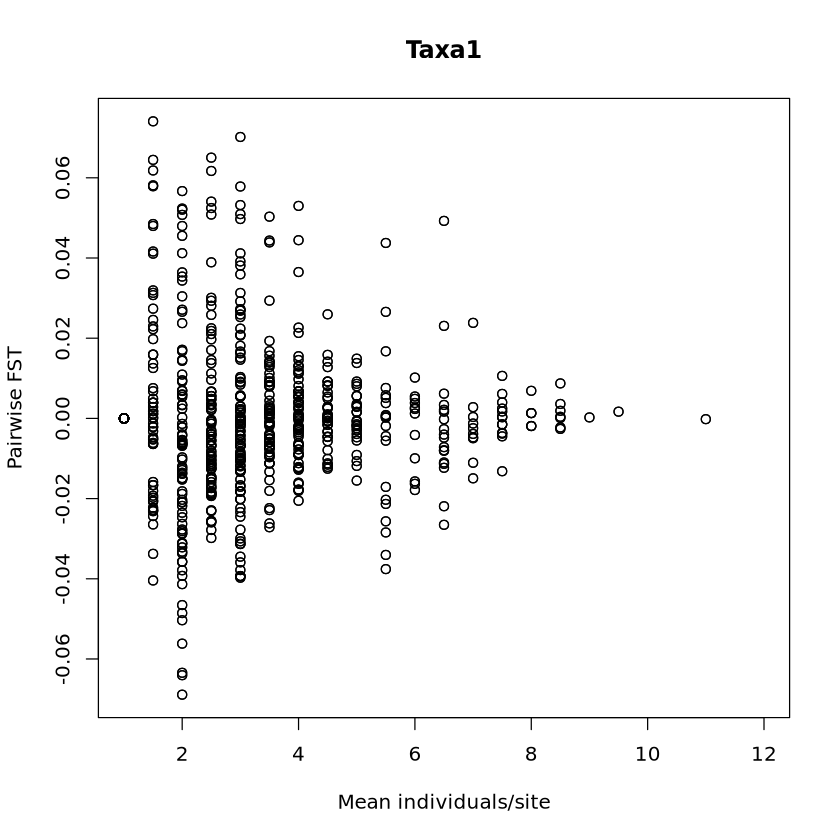

In [30]:
plot(fst1_long$mean_counts,fst1_long$fst,main="Taxa1",xlab="Mean individuals/site",ylab="Pairwise FST")

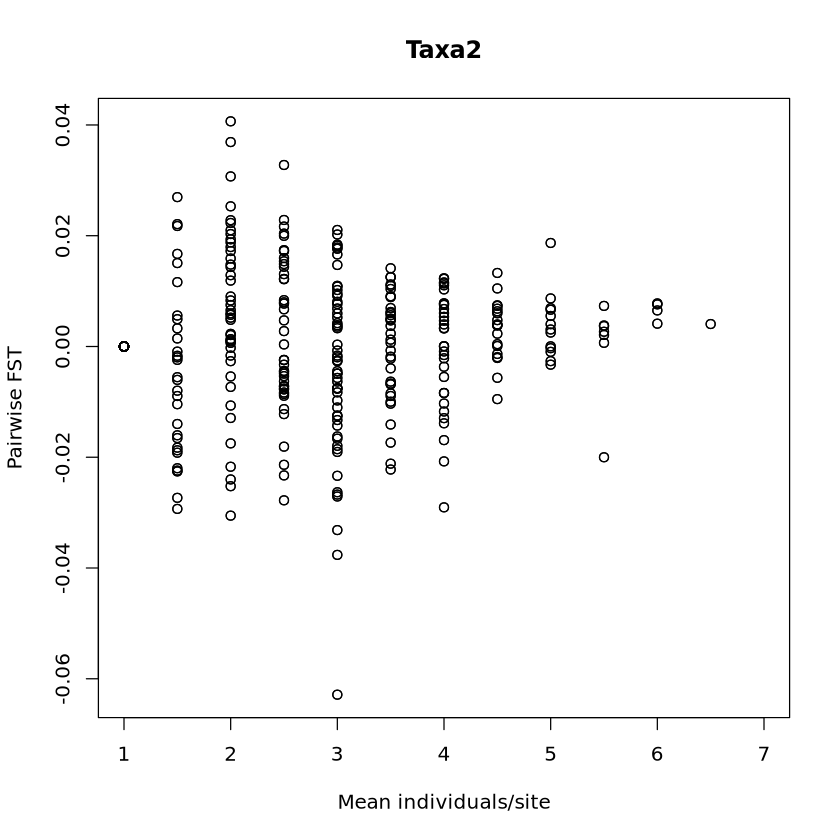

In [31]:
plot(fst2_long$mean_counts,fst2_long$fst,main="Taxa2",xlab="Mean individuals/site",ylab="Pairwise FST")

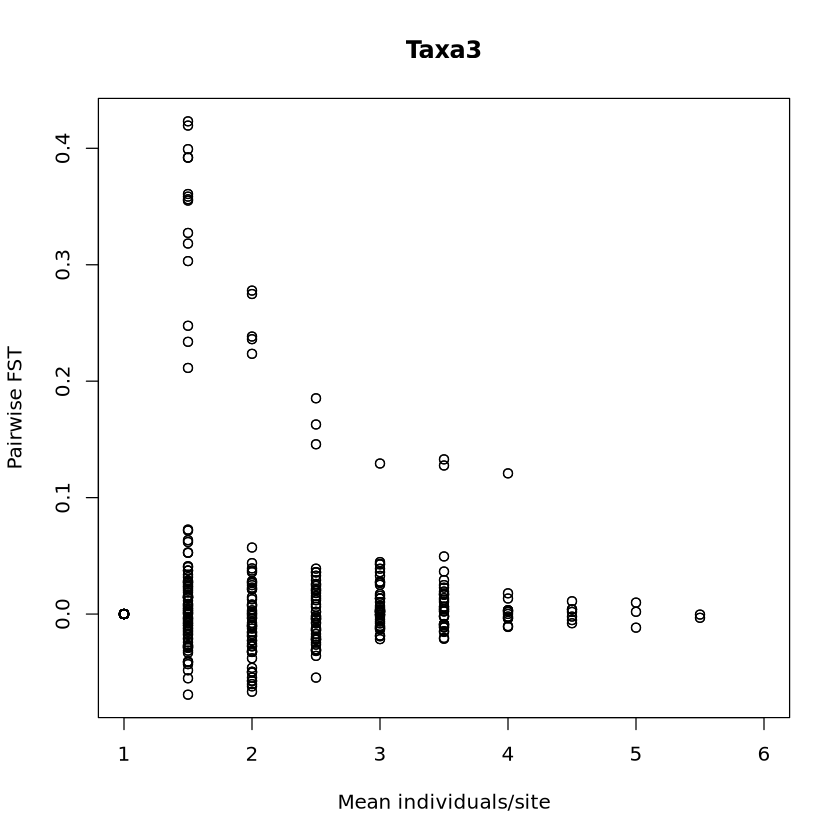

In [32]:
plot(fst3_long$mean_counts,fst3_long$fst,main="Taxa3",xlab="Mean individuals/site",ylab="Pairwise FST")

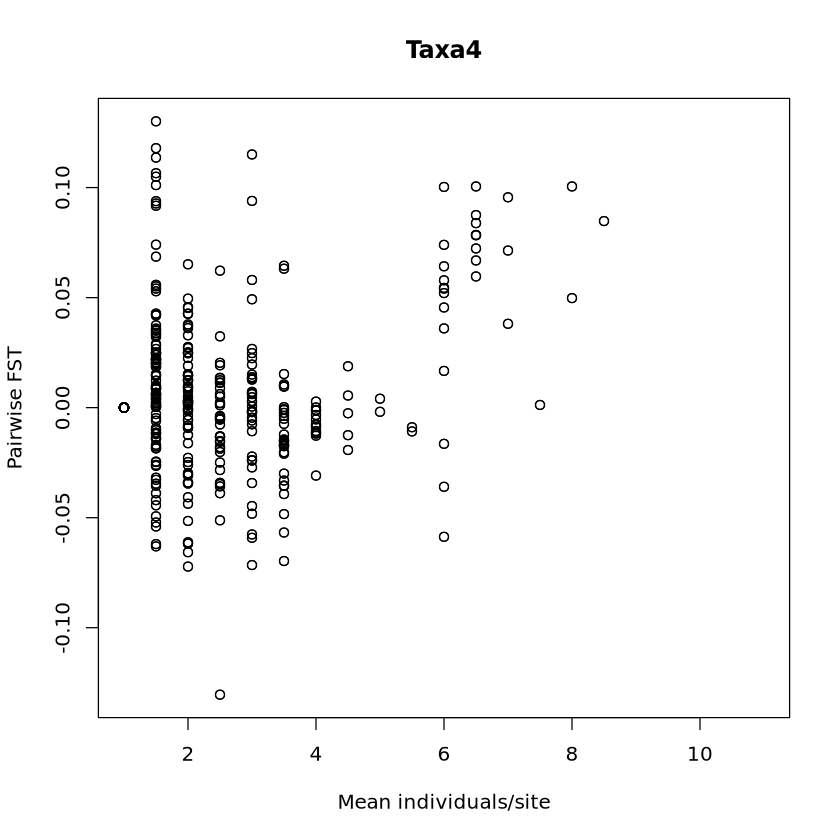

In [33]:
plot(fst4_long$mean_counts,fst4_long$fst,main="Taxa4",xlab="Mean individuals/site",ylab="Pairwise FST")

In [31]:
#Convert wide form FSTs to linearized wide form FSTs for use in Mantel test
fst_lin1<-as.data.frame(linear_fsts(fst1))
fst_lin2<-as.data.frame(linear_fsts(fst2))
fst_lin3<-as.data.frame(linear_fsts(fst3))
fst_lin4<-as.data.frame(linear_fsts(fst4))

Run Mantel tests for each cryptic taxon. Note that these are Mantel tests for both Cebu and Leyte together!

In [32]:
#Mantel test, taxa 1
mantel(fst_lin1,dists1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin1, ydis = dists1) 

Mantel statistic r: -0.04517 
      Significance: 0.735 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.105 0.141 0.172 0.201 
Permutation: free
Number of permutations: 999


In [33]:
#Mantel test, taxa 2
mantel(fst_lin2,dists2)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin2, ydis = dists2) 

Mantel statistic r: -0.06471 
      Significance: 0.795 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0848 0.1090 0.1271 0.1508 
Permutation: free
Number of permutations: 999


In [34]:
#Mantel test, taxa 3
mantel(fst_lin3,dists3)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin3, ydis = dists3) 

Mantel statistic r: 0.1326 
      Significance: 0.124 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.153 0.180 0.201 0.221 
Permutation: free
Number of permutations: 999


In [35]:
#Mantel test, taxa 4
mantel(fst_lin4,dists4)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst_lin4, ydis = dists4) 

Mantel statistic r: -0.1034 
      Significance: 0.905 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.104 0.146 0.172 0.195 
Permutation: free
Number of permutations: 999


In [95]:
#Merge wide form linearized FSTs and wide form distances to long form dataframes of linearized FSTs and pairwise distances
merge1<-fst_dist_join(fst_lin1,dists1)
merge2<-fst_dist_join(fst_lin2,dists2)
merge3<-fst_dist_join(fst_lin3,dists3)
merge4<-fst_dist_join(fst_lin4,dists4)

Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`
Joining with `by = join_by(SiteA, SiteB)`


In [98]:
#Create datasets with Cebu only
merge1_Ceb<-Ceb_merge(merge1)
merge2_Ceb<-Ceb_merge(merge2)
merge3_Ceb<-Ceb_merge(merge3)
merge4_Ceb<-Ceb_merge(merge4)

Calculate Des (estimates of individual density per meter or square meter) for one and two dimensions for each taxon. One dimensional estimates use Cebu data only. All Nes and upper and lower Ne bounds come from NeEstimator

In [99]:
maxCeb<-as.numeric(max(merge1_Ceb$Distance_m))

In [100]:
#Create convex hull around points
sites_st<-st_as_sf(sites,coords=c('LONGITUDE','LATITUDE'))
sites_st<-st_set_crs(sites_st,4326)
sitepoints<-st_combine(sites_st)
site_polygon<-st_convex_hull(sitepoints)

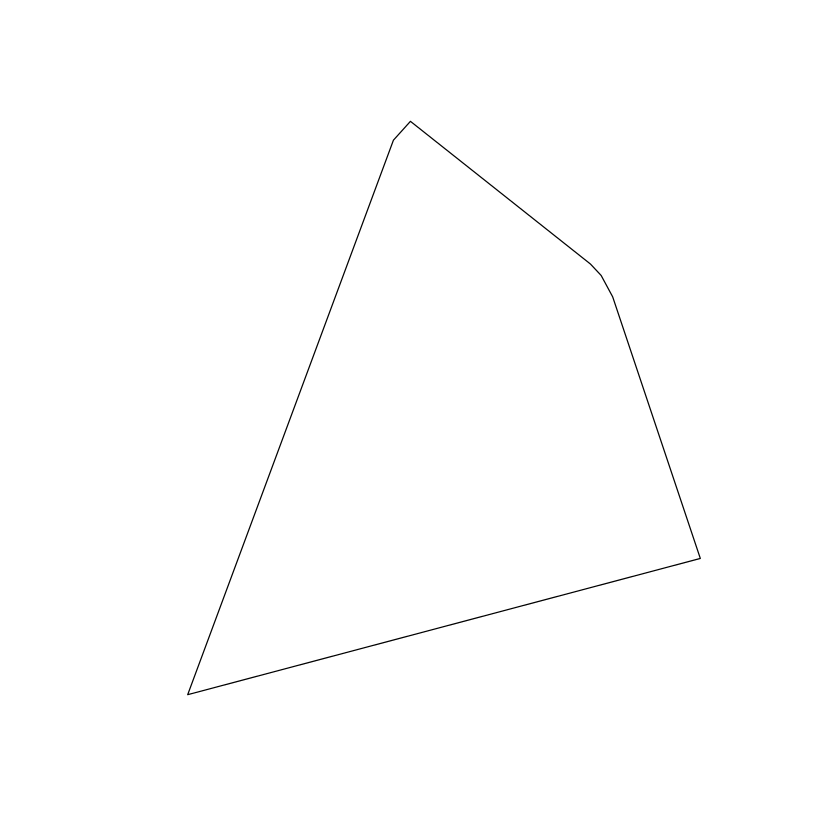

In [101]:
plot(site_polygon)
area_2d<-as.numeric(st_area(site_polygon))

In [102]:
Des1_1d<-DeFromNb(1000,20,5, 634.8,587.5, 661.0, maxCeb)
Des1_2d<-DeFromNb(1000,20,5,522.7,482.5,513.8,area_2d)

Des2_1d<-DeFromNb(1000,20,5,525.7,445.5,516.0,maxCeb)
Des2_2d<-DeFromNb(1000,20,5,260.3,250.9,265.7,area_2d)

Des4_1d<-DeFromNb(1000,20,5,40.3,40,41.2,maxCeb)
Des4_1d_jackknife<-DeFromNb(1000,20,5,40.3,28,65,maxCeb)
Des4_2d<-DeFromNb(1000,20,5,47.4,46.9,48.1,area_2d)

Des3_1d<-DeFromNb(1000,20,5,118.5,132.8,138.2,maxCeb)
Des3_2d<-DeFromNb(1000,20,5,148.1,147.1,152.7,area_2d)

#AL = filling in 20 for now, but will ask Isabel. Citation: https://www.int-res.com/abstracts/meps/v333/p143-150/

In [104]:
merge1$Dist_log<-log(merge1$Distance_m)
merge2$Dist_log<-log(merge2$Distance_m)
merge3$Dist_log<-log(merge3$Distance_m)
merge4$Dist_log<-log(merge4$Distance_m)

In [105]:
#Calculate IBD slopes (m) in one and two dimensions for each taxon. One diemnsional estimates use Cebu data only
m1<-summary(lm(Lin_FST ~ Dist_log,dat=merge1))$coefficients[2,1]
m2<-summary(lm(Lin_FST ~ Dist_log,dat=merge2))$coefficients[2,1]
m3<-summary(lm(Lin_FST ~ Dist_log,dat=merge3))$coefficients[2,1]
m4<-summary(lm(Lin_FST ~ Dist_log,dat=merge4))$coefficients[2,1]

m1_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge1_Ceb))$coefficients[2,1]
m2_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge2_Ceb))$coefficients[2,1]
m3_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge3_Ceb))$coefficients[2,1]
m4_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge4_Ceb))$coefficients[2,1]

In [106]:
#Calculate standard errors of IBD slopes in one and two dimensions for each taxon. One diemnsional estimates use Cebu data only
se1<-summary(lm(Lin_FST ~ Dist_log,dat=merge1))$coefficients[2,2]*1.96
se2<-summary(lm(Lin_FST ~ Dist_log,dat=merge2))$coefficients[2,2]*1.96
se3<-summary(lm(Lin_FST ~ Dist_log,dat=merge3))$coefficients[2,2]*1.96
se4<-summary(lm(Lin_FST ~ Dist_log,dat=merge4))$coefficients[2,2]*1.96

se1_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge1_Ceb))$coefficients[2,2]*1.96
se2_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge2_Ceb))$coefficients[2,2]*1.96
se3_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge3_Ceb))$coefficients[2,2]*1.96
se4_Ceb<-summary(lm(Lin_FST ~ Distance_m,dat=merge4_Ceb))$coefficients[2,2]*1.96

In [107]:
m1s<-rnorm(1000, mean = m1, sd = se1)
m2s<-rnorm(1000, mean = m2, sd = se2)
m3s<-rnorm(1000, mean = m3, sd = se3)
m4s<-rnorm(1000, mean = m4, sd = se4)

m1_Cs<-rnorm(1000, mean = m1_Ceb, sd = se1_Ceb)
m2_Cs<-rnorm(1000, mean = m2_Ceb, sd = se2_Ceb)
m3_Cs<-rnorm(1000, mean = m3_Ceb, sd = se3_Ceb)
m4_Cs<-rnorm(1000, mean = m4_Ceb, sd = se4_Ceb)

ms_2d <- data.frame(
  value = c(m1s*1000, m2s*1000, m3s*1000, m4s*1000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

ms_1d <- data.frame(
  value = c(m1_Cs*1000, m2_Cs*1000, m3_Cs*1000, m4_Cs*1000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

In [108]:
Des_1d<-data.frame(
  value = c(Des1_1d$Des*1000, Des2_1d$Des*1000, Des3_1d$Des*1000, Des4_1d$Des*1000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

Des_2d<-data.frame(
  value = c(Des1_2d$Des*1000000, Des2_2d$Des*1000000, Des3_2d$Des*1000000, Des4_2d$Des*1000000),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

In [109]:
#Calculate distribution of 1000 sigmas for all 1d (Cebu) kernels. Produces some NaNs (infinity)
sigmas1_1d<-sigmaFrom_m(Des1_1d$De,Des1_1d$Des,m1_Ceb,se1_Ceb,dims=1)
sigmas2_1d<-sigmaFrom_m(Des2_1d$De,Des2_1d$Des,m2_Ceb,se2_Ceb,dims=1)
sigmas3_1d<-sigmaFrom_m(Des3_1d$De,Des3_1d$Des,m3_Ceb,se3_Ceb,dims=1)
sigmas4_1d<-sigmaFrom_m(Des4_1d$De,Des4_1d$Des,m4_Ceb,se4_Ceb,dims=1)

Warning message in sqrt(1/(4 * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * Des * ms)):
“NaNs produced”


In [110]:
#Calculate distribution of 1000 sigmas for all 2d kernels. Produces some NaNs (infinity)
sigmas1_2d<-sigmaFrom_m(Des1_2d$De,Des1_2d$Des,m1,se1,dims=2)
sigmas2_2d<-sigmaFrom_m(Des2_2d$De,Des2_2d$Des,m2,se2,dims=2)
sigmas3_2d<-sigmaFrom_m(Des3_2d$De,Des3_2d$Des,m3,se3,dims=2)
sigmas4_2d<-sigmaFrom_m(Des4_2d$De,Des4_2d$Des,m4,se4,dims=2)

Warning message in sqrt(1/(4 * pi * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * De * m)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”
Warning message in sqrt(1/(4 * pi * Des * ms)):
“NaNs produced”


In [122]:
#Make dataframe of all 1d sigmas for boxplot
sigmas_1d <- data.frame(
  value = c(sigmas1_1d$sigmas, sigmas2_1d$sigmas, sigmas3_1d$sigmas, sigmas4_1d$sigmas),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

In [123]:
#Convert from m to km and assign boxplot colors for each taxon
sigmas_1d$value<-sigmas_1d$value/1000
plot_colors <- c("#440154FF", "#31688EFF", "#35B779FF", "#FDE725FF")

In [124]:
#Make density plot
sigmas_density_1d<-ggplot(sigmas_1d, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(xlim = c(-1, 400)) +
  theme_classic() +
  labs(x = "Width of dispersal kernel, km",x="Density")+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SigmasDensity_1d.png",plot= sigmas_density_1d,dpi=1200,units='in',width=8,height=4)

Warning message:
“Removed 2128 rows containing non-finite outside the scale range (`stat_density()`).”


Warning message:
“Removed 2128 rows containing non-finite outside the scale range (`stat_density()`).”


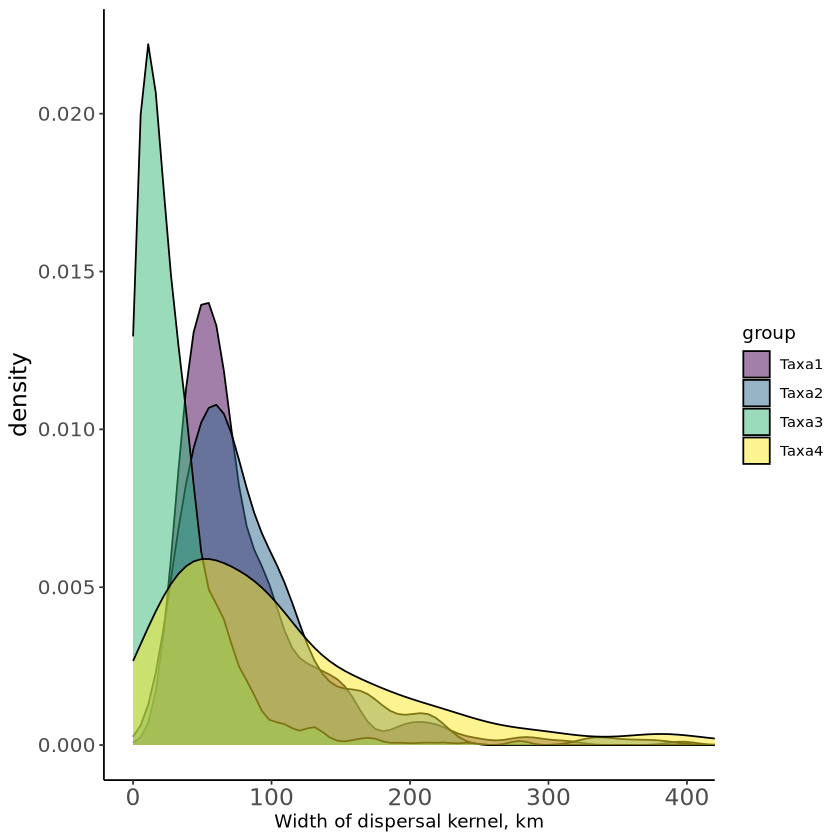

In [125]:
sigmas_density_1d

In [126]:
#Make density plot of slopes 1d
slopes_density_1d<-ggplot(ms_1d, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  #coord_cartesian(xlim = c(-1, 400)) +
  theme_classic() +
  labs(x = "Estimated slopes",x="Density")+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SlopesDensity_1d.png",plot= slopes_density_1d,dpi=1200,units='in',width=8,height=4)

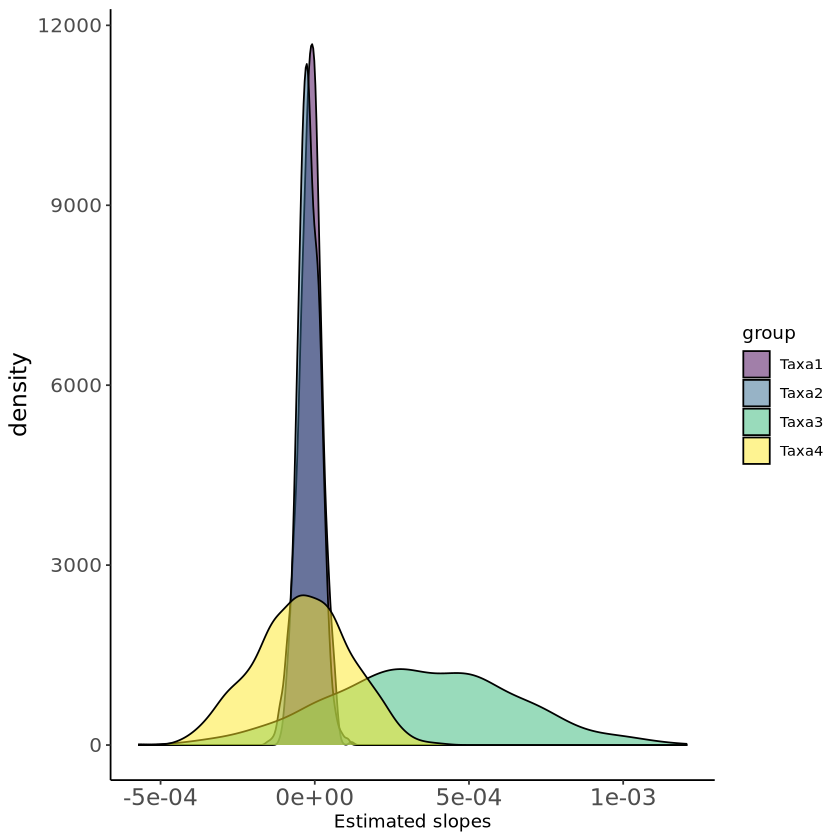

In [127]:
slopes_density_1d

In [128]:
#Make density plot of slopes 2d
slopes_density_2d<-ggplot(ms_2d, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  #coord_cartesian(xlim = c(-1, 400)) +
  theme_classic() +
  labs(x = "Estimated slopes",x="Density")+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SlopesDensity_2d.png",plot= slopes_density_2d,dpi=1200,units='in',width=8,height=4)

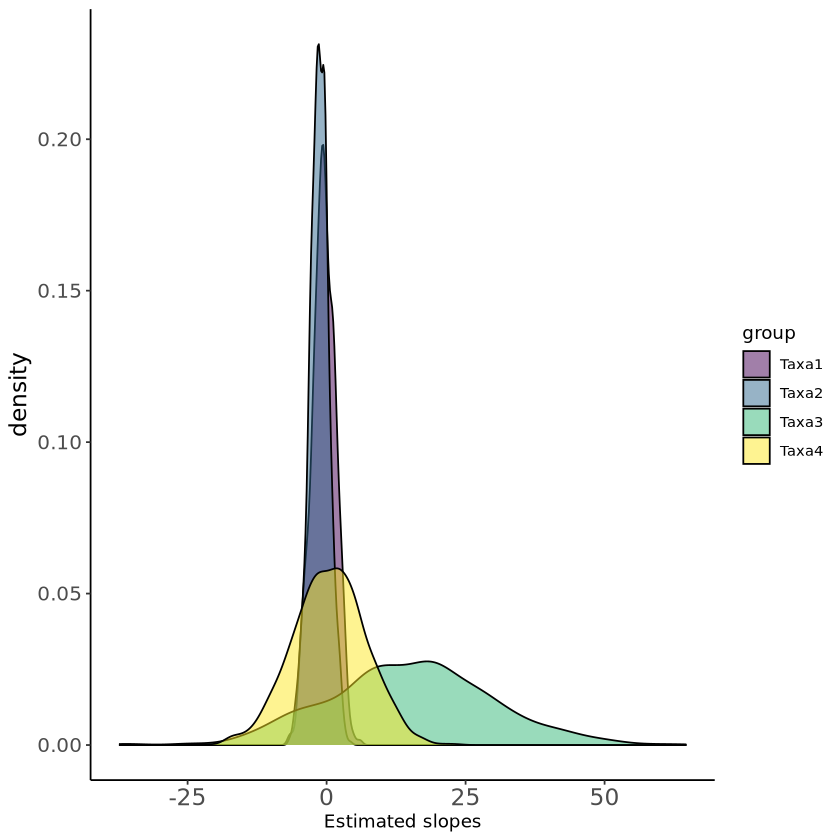

In [129]:
slopes_density_2d

In [131]:
Big_1d_Des<-Des_1d[Des_1d$value>1000,]

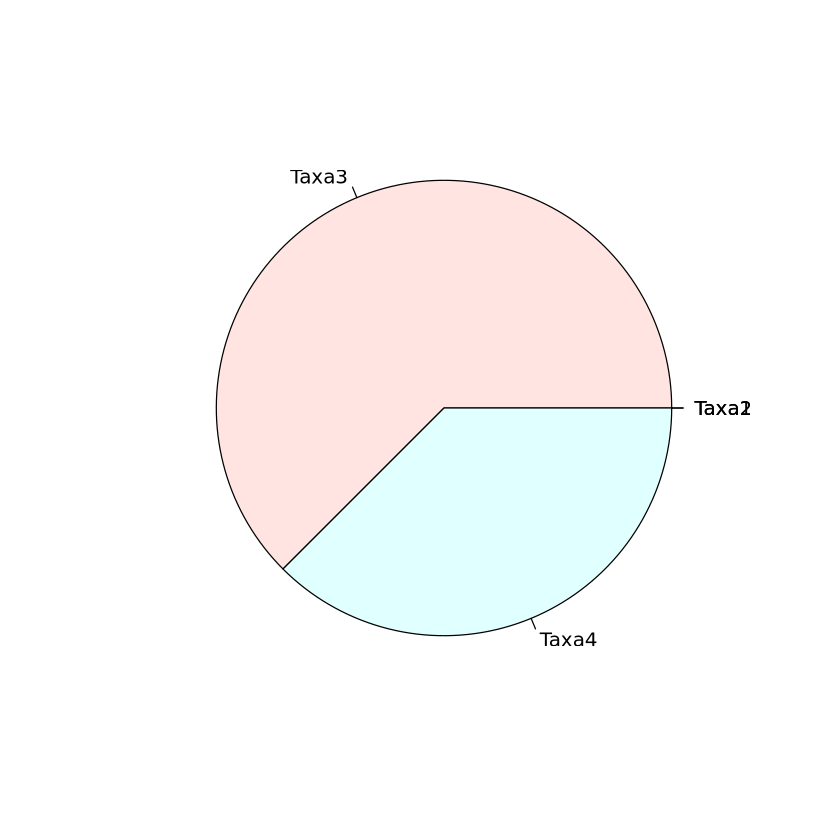

In [132]:
pie(table(Big_1d_Des$group))

In [134]:
Des_1d_ok<-Des_1d[Des_1d$value<1000,]

In [135]:
#Make density plot of Des 1d
Des_density_1d<-ggplot(Des_1d_ok, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(xlim = c(0, 20)) +
  theme_classic() +
  labs(x = "Estimated individuals/km",x=NULL)+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="DesDensity_1d.png",plot= Des_density_1d,dpi=1200,units='in',width=8,height=4)

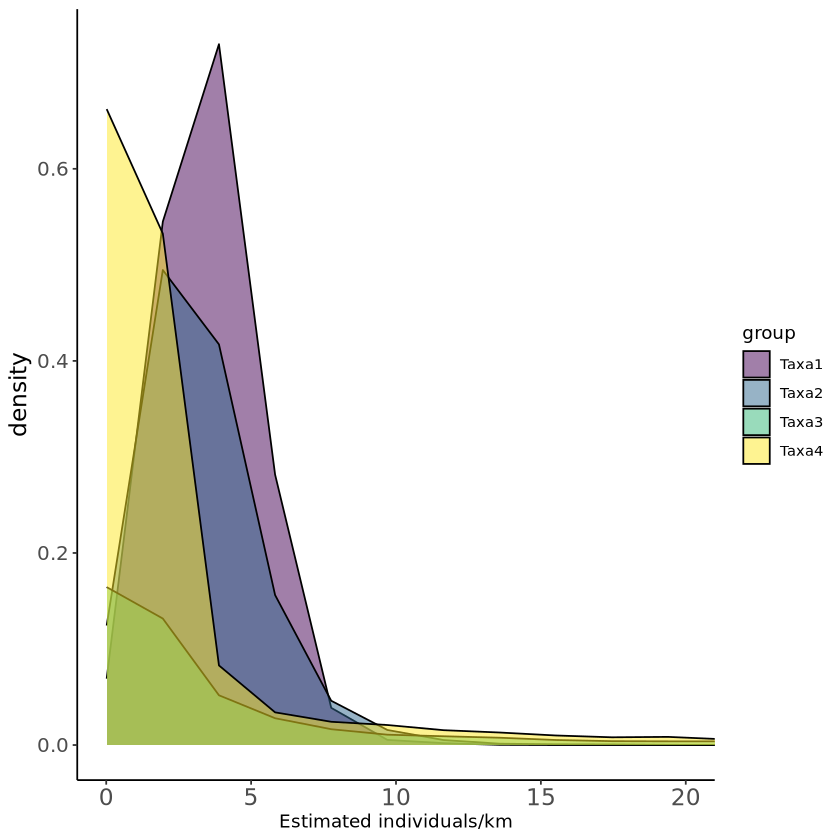

In [136]:
Des_density_1d

In [138]:
Des_2d_ok<-Des_2d[Des_2d$value<100,]

In [139]:
Des_density_2d<-ggplot(Des_2d_ok, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(xlim = c(0, 1)) +
  theme_classic() +
  labs(x = "Estimated individuals/km2",x=NULL)+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="DesDensity_2d.png",plot= Des_density_2d,dpi=1200,units='in',width=8,height=4)

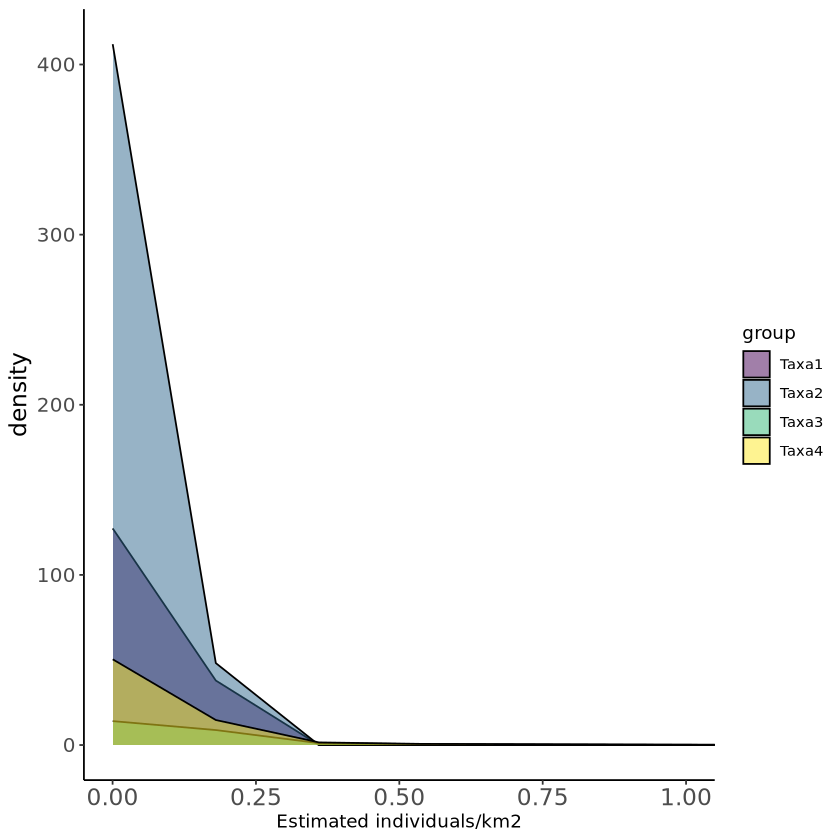

In [140]:
Des_density_2d

In [141]:
#Make boxplot
sigmas_boxplot<-ggplot(sigmas_1d, aes(x = group, y = value, fill = group)) +
  geom_boxplot() +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(ylim = c(-1, 400)) +
  theme_classic() +
  labs(y = "Width of dispersal kernel, km",x=NULL)+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SigmasBoxplot_1d.png",plot= sigmas_boxplot,dpi=800,units='in',width=8,height=4)

Warning message:
“Removed 2128 rows containing non-finite outside the scale range (`stat_boxplot()`).”


Warning message:
“Removed 2128 rows containing non-finite outside the scale range (`stat_boxplot()`).”


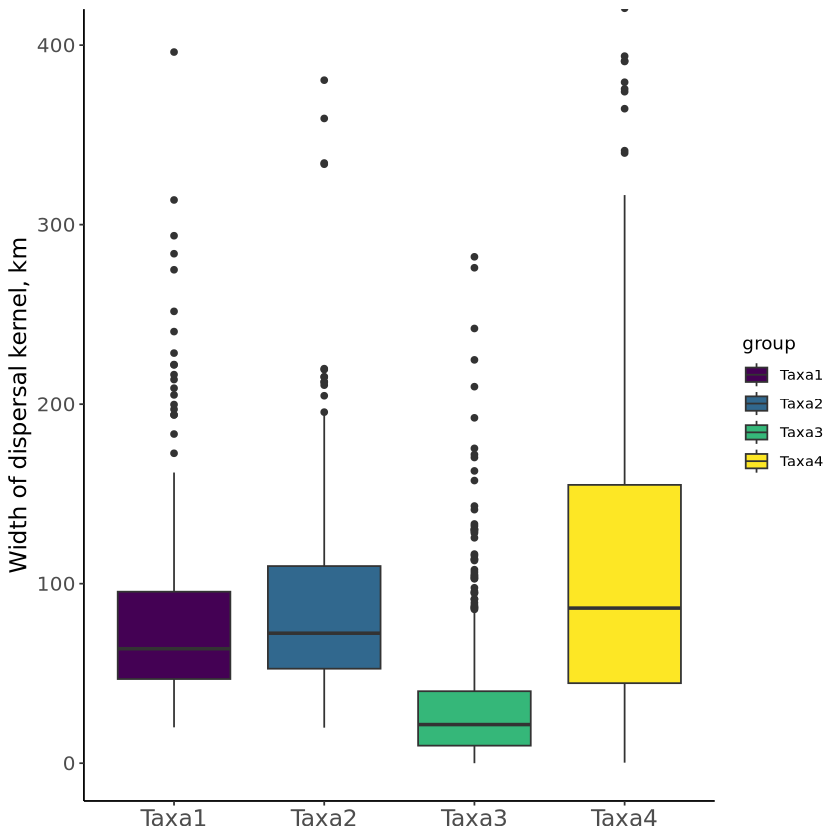

In [142]:
sigmas_boxplot

In [143]:
#Get median of each sigma estimate in km
median(sigmas1_1d$sigmas,na.rm=TRUE)/1000
median(sigmas2_1d$sigmas,na.rm=TRUE)/1000
median(sigmas3_1d$sigmas,na.rm=TRUE)/1000
median(sigmas4_1d$sigmas,na.rm=TRUE)/1000

[1] 63.75671

[1] 72.40532

[1] 21.51511

[1] 86.39413

In [144]:
#Make dataframe of all 1d sigmas for boxplot
sigmas_2d <- data.frame(
  value = c(sigmas1_2d$sigmas, sigmas2_2d$sigmas, sigmas3_2d$sigmas, sigmas4_2d$sigmas),
  group = factor(rep(c("Taxa1", "Taxa2", "Taxa3", "Taxa4"), each = 1000))
)

In [145]:
#Convert from m to km and assign boxplot colors for each taxon
sigmas_2d$value<-sigmas_2d$value/1000
plot_colors <- c("#440154FF", "#31688EFF", "#35B779FF", "#FDE725FF")

In [146]:
#Make density plot
sigmas_density_2d<-ggplot(sigmas_2d, aes(x = value, fill = group)) +
  geom_density(alpha=0.5) +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(xlim = c(-1, 150)) +
  theme_classic() +
  labs(x = "Width of dispersal kernel, km squared",x="Density")+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SigmasDensity_2d.png",plot= sigmas_density_2d,dpi=1200,units='in',width=8,height=4)

Warning message:
“Removed 2006 rows containing non-finite outside the scale range (`stat_density()`).”


Warning message:
“Removed 2006 rows containing non-finite outside the scale range (`stat_density()`).”


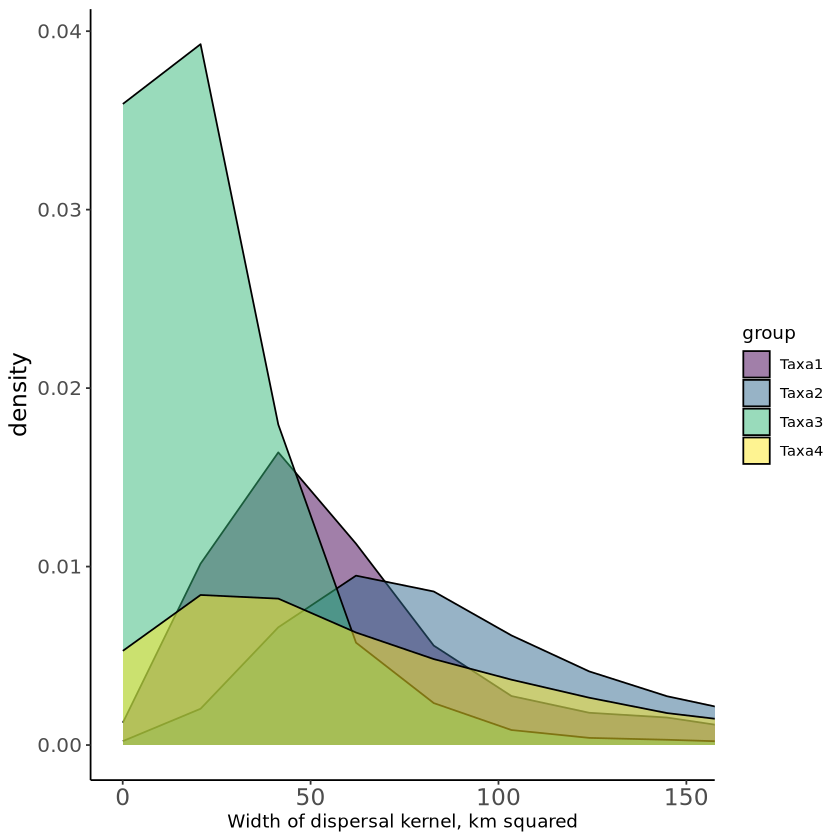

In [147]:
sigmas_density_2d

In [156]:
#Make boxplot
sigmas_boxplot2<-ggplot(sigmas_2d, aes(x = group, y = value, fill = group)) +
  geom_boxplot() +
  scale_fill_manual(values = plot_colors) +
  coord_cartesian(ylim = c(0, 300)) +
  theme_classic() +
  labs(y = "Width of dispersal kernel, km2",x=NULL)+
  theme(plot.title = element_text(size = 18),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 12))
ggsave(filename="SigmasBoxplot_2d.png",plot= sigmas_boxplot2,dpi=800,units='in',width=8,height=4)

Warning message:
“Removed 2006 rows containing non-finite outside the scale range (`stat_boxplot()`).”


Warning message:
“Removed 2006 rows containing non-finite outside the scale range (`stat_boxplot()`).”


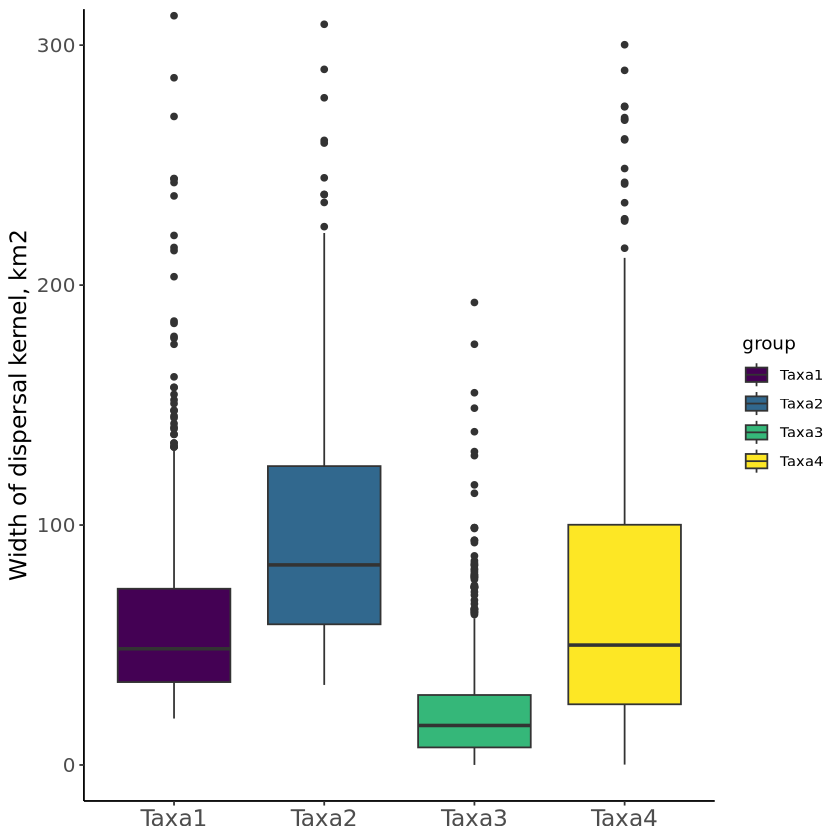

In [157]:
sigmas_boxplot2

In [158]:
#Get median of each sigma estimate in km
median(sigmas1_2d$sigmas,na.rm=TRUE)/1000
median(sigmas2_2d$sigmas,na.rm=TRUE)/1000
median(sigmas3_2d$sigmas,na.rm=TRUE)/1000
median(sigmas4_2d$sigmas,na.rm=TRUE)/1000

[1] 48.43176

[1] 83.38475

[1] 16.46709

[1] 49.97764

In [159]:
join_for_fig<-function(merged_data,long_fsts){
    merged_data$SiteAB<-paste(merged_data$SiteA,merged_data$SiteB)
    long_fsts$SiteAB<-paste(long_fsts$siteA,long_fsts$siteB)
    new<-left_join(merged_data,long_fsts,by='SiteAB')
    new<-new[,c('SiteA','SiteB','Lin_FST','Distance_m','mean_counts')]
    }

In [160]:
figdat1<-join_for_fig(merge1,fst1_long)
figdat2<-join_for_fig(merge2,fst2_long)
figdat3<-join_for_fig(merge3,fst3_long)
figdat4<-join_for_fig(merge4,fst4_long)

In [161]:
fst_plot<-function(data,color,title,ul=0.5,xlabel=NULL,ylabel=NULL){
  pl<-ggplot(data, aes(x = as.numeric(Distance_m), y = Lin_FST,size = mean_counts)) +
  geom_point(col=color,alpha =0.5) +
  geom_smooth(method = "lm",se=FALSE,col=color,show.legend = FALSE) +
  scale_size_continuous(name = "Mean samples per site pair", range = c(0.5, 0.5*max(data$mean_counts))) +
  #ggtitle(title) + 
  annotate("text",x=100000,y=0.6,label="R-squared=",size=6) +
  annotate("text",x=100000,y=0.4,label=signif(summary(lm(Lin_FST~Distance_m,dat=data))$adj.r.squared,digits=2),size=6)+
    xlab(xlabel) +
    ylab(ylabel) +
    theme_minimal() +
    ylim(-0.1, ul) + 
    theme(plot.title = element_text(size = 18),
          axis.title.x = element_text(size = 14),
          #axis.title.y = element_text(size = 14),
          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 12),
          #axis.text.x = element_blank(),
          #axis.text.y = element_text(size = 12),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          #axis.ticks.x= element_blank(),
          legend.position = "none")
 return(pl) 
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in the
  data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable
  into a factor?”


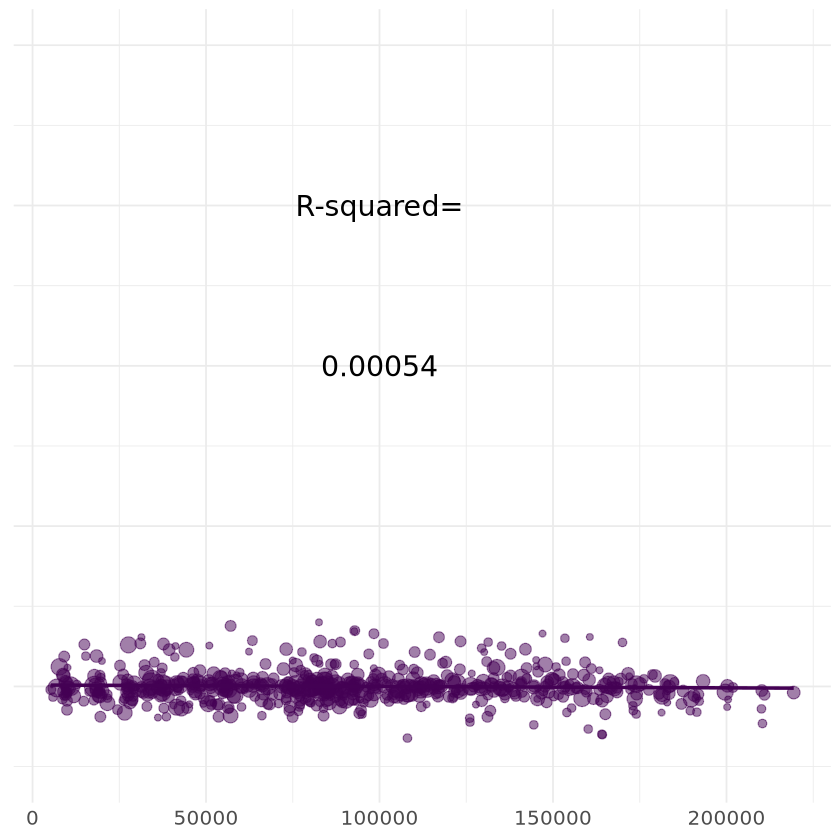

In [162]:
fst_plot(figdat1,"#440154FF",'Taxa 1',ul=0.8,ylabel="Pairwise linearized FST")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in the
  data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable
  into a factor?”


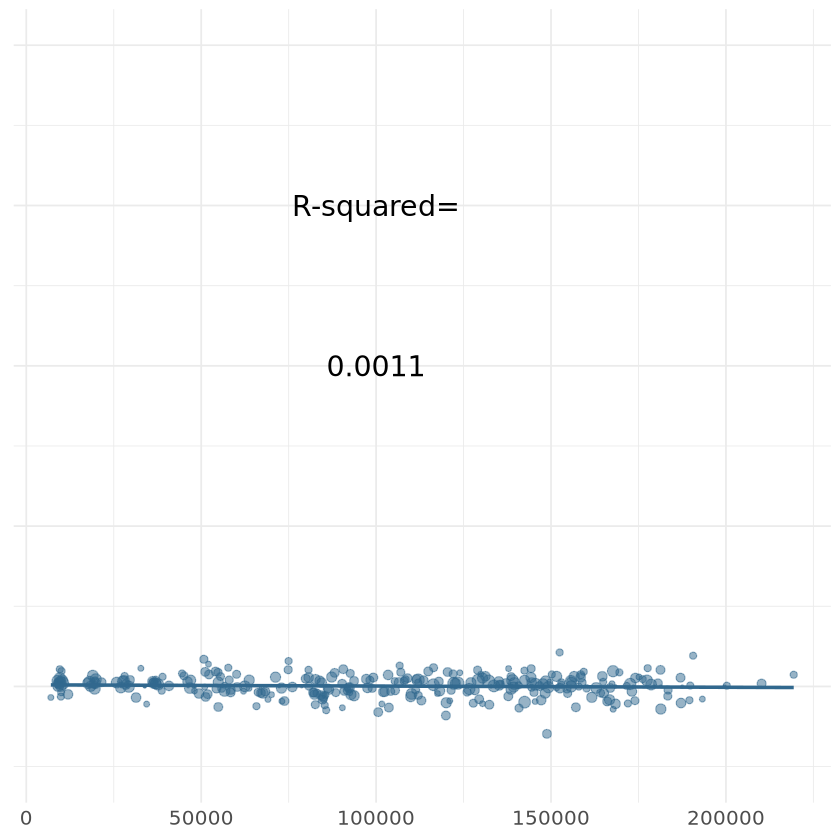

In [163]:
fst_plot(figdat2,"#31688EFF",'Taxa 2',ul=0.8,ylabel="Pairwise linearized FST")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in the
  data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable
  into a factor?”


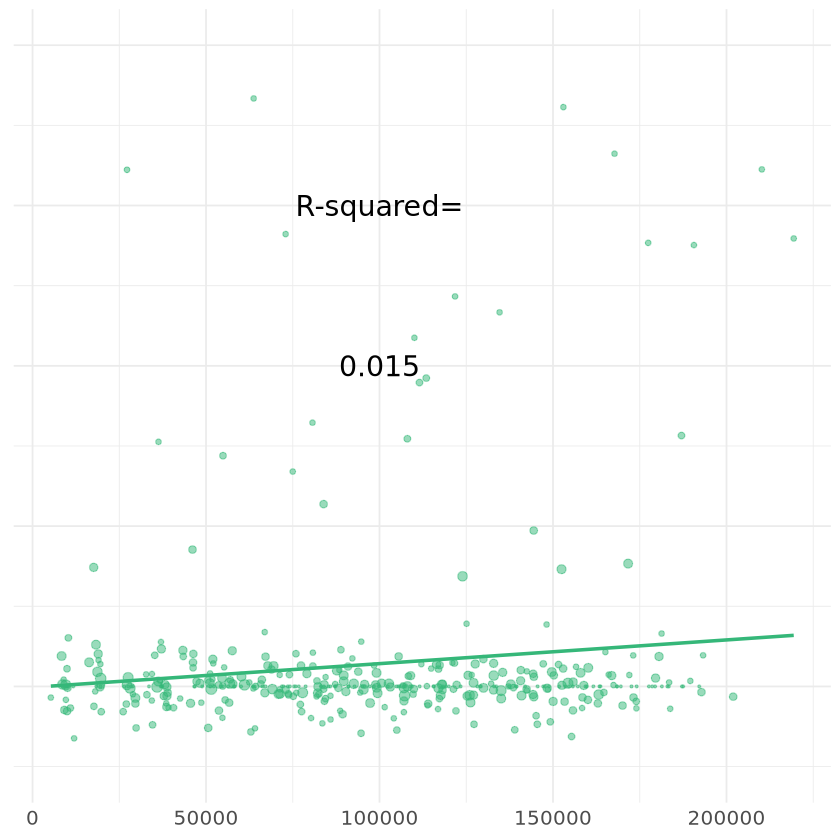

In [164]:
fst_plot(figdat3,"#35B779FF",'Taxa 2',ul=0.8,ylabel="Pairwise linearized FST")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in the
  data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable
  into a factor?”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


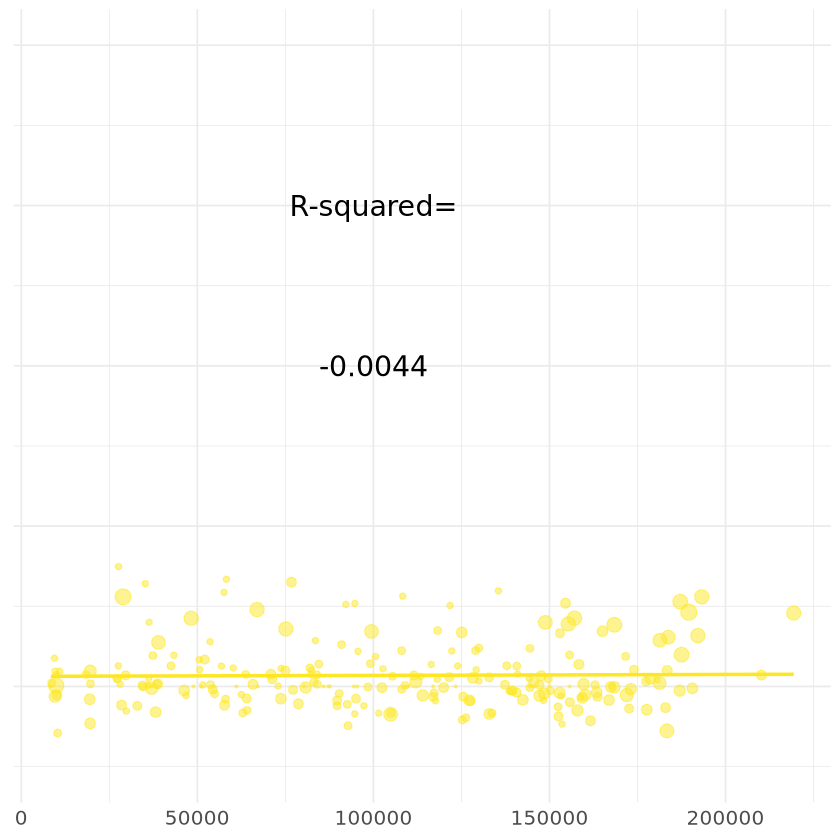

In [165]:
fst_plot(figdat4,"#FDE725FF",'Taxa 2',ul=0.8,ylabel="Pairwise linearized FST")